# Simulating Heat Diffusion to Cook a Chicken with Numba and CUDA

In this notebook, we'll attemp tolving the 2-dimensional heat equation to simulate how heat diffuses through a chicken as it cooks in the oven. 

To start, we'll use a simplified 2D representation of a chicken.

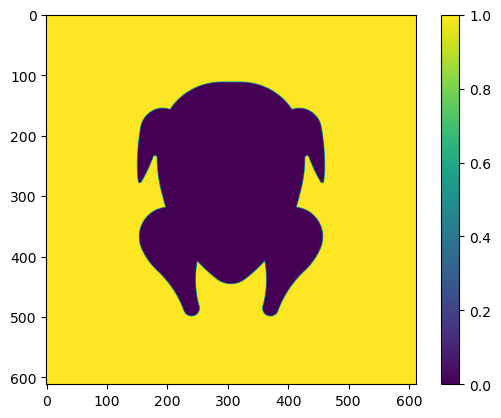

In [1]:
import numpy as np
from numba import cuda, njit, prange
import matplotlib.pyplot as plt

# Load the 2D image representation of the chicken
image = plt.imread('chicken.png')
height, width = image.shape
plt.imshow(image)
plt.colorbar()

To simulate heat diffusion in our 2D "chicken" grid, we'll assume that:

- The oven has a width of 50 cm.
- The oven temperature is set to 200°C.
- The chicken's initial internal temperature is 20°C.
- Heat diffusion across the chicken will be governed by the 2D heat equation.

Given the temperature field $u = u(x, y, z; t)$, the heat equation describing the change over time is:
$$
\frac{\partial u}{\partial t} = \alpha \nabla^2 u 
$$

where:
- $\alpha$ is the thermal diffusivity of the chicken, in units of $m^2/s$.
  
For chicken, $\alpha$ has been measured (!) to be approximately $1.32 \times 10^{-7} \, \text{m}^2/\text{s} $, allowing us to model how heat penetrates and warms the chicken over time.

To simulate heat transfer over time, we'll need to update the temperature of each "pixel" representing the chicken at each time step.

### Simulation Parameters
- Total simulation time: 1 hour
- Time step: $\Delta t = 1 \, \text{s}$

### Discretizing the Heat Equation

The continuous heat equation can be expressed as:
$$
\frac{\partial u}{\partial t} = \alpha \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

To implement this, we discretize the equation in both time and space.

Let $u_{i,j}^{\tau}$ represent the temperature at pixel $(i, j)$ at time $\tau$. The discrete form of the equation then becomes:

$$
\frac{u_{i,j}^{\tau+1} - u_{i,j}^{\tau}}{\Delta t} = \alpha \left( \frac{u_{i+1,j}^{\tau} - 2u_{i,j}^{\tau} + u_{i-1,j}^{\tau}}{\Delta x^2} + \frac{u_{i,j+1}^{\tau} - 2u_{i,j}^{\tau} + u_{i,j-1}^{\tau}}{\Delta y^2} \right)
$$

This formulation allows us to iteratively update each pixel's temperature at every time step.

To update the temperature field at the next time step $\tau+1$, we use the current state of the temperature field at time $\tau$.

Assuming that each pixel represents an equal spatial step size along both $x(i)$ and $y(j)$ axes, we set $\Delta x = \Delta y = \Delta s$.

The update rule for each pixel $(i, j)$ at time $\tau+1$ then becomes:

$$
u_{i,j}^{\tau+1} = u_{i,j}^{\tau} + \alpha \frac{\Delta t}{\Delta s^2} \left( u_{i+1,j}^{\tau} + u_{i-1,j}^{\tau} + u_{i,j+1}^{\tau} + u_{i,j-1}^{\tau} - 4u_{i,j}^{\tau} \right)
$$

This equation allows us to iteratively compute the temperature at each pixel for the next time step, based on its current state and the temperatures of its neighboring pixels.

This is finally the equation we would like to solve for all pixels of our chicken and for all timesteps.

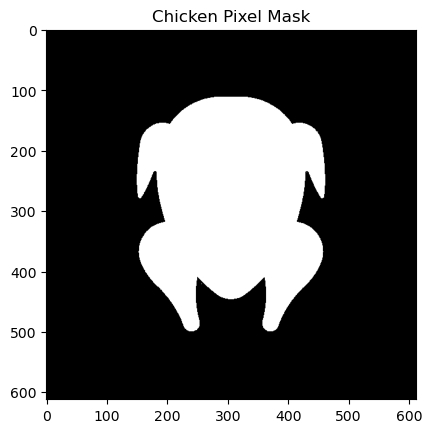

In [2]:
# Create a mask to identify the "chicken" pixels within the image
# Here, pixels with values less than 0.9 are considered part of the chicken
mask = image < 0.9

# Display the mask to verify which pixels belong to the chicken
plt.imshow(mask, cmap='gray')
plt.title("Chicken Pixel Mask")
plt.show()

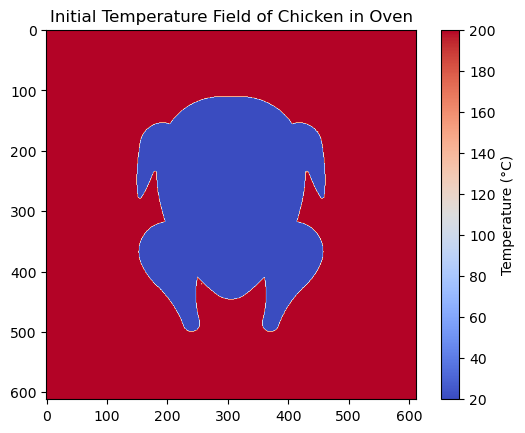

In [3]:
# Initialize the temperature field
T_oven = 200.0  # Oven temperature in degrees Celsius
T_chicken = 20.0  # Initial chicken temperature in degrees Celsius

# Create a 2D array representing the temperature field, setting all pixels initially to the oven temperature
T_initial = np.full((height, width), T_oven, dtype=np.float32)

# Set the initial temperature of the chicken pixels based on the mask
T_initial[mask] = T_chicken

# Display the initial temperature distribution
plt.imshow(T_initial, cmap='coolwarm', vmin=T_chicken, vmax=T_oven)
plt.colorbar(label="Temperature (°C)")
plt.title("Initial Temperature Field of Chicken in Oven")
plt.show()

In [4]:
# Parameters for the heat equation
oven_width = 0.5                # Width of the oven in meters
alpha = 1.32e-7                 # Thermal diffusivity of chicken in m^2/s
dx = oven_width / width         # Spatial step size in meters (based on pixel size)
dt = 1.0                        # Time step size in seconds
time = 3600.0                   # Total cooking time in seconds (1 hour)
num_steps = int(time / dt)      # Total number of time steps

# Precompute constant factor for the heat equation to simplify computation
dt_dx2 = dt / (dx ** 2)         # This factor is used frequently in the update equation

## Numba CPU implementation

Write the purely-CPU implementation of the task using Numba

In [5]:
# Numba heat equation function on CPU
@njit(parallel=True)
def heat_equation_cpu(Temp, Mask, Alpha, Dt_dx2, Num_steps):
    """
    Simulates heat diffusion over time on the CPU using Numba.

    Parameters:
    - Temp: 2D array representing the temperature field.
    - Mask: 2D boolean array indicating chicken pixels.
    - Alpha: Thermal diffusivity of the material (m^2/s).
    - Dt_dx2: Precomputed constant value for the heat equation.
    - Num_steps: Total number of time steps to simulate.

    Returns:
    - Updated temperature field after simulation.
    """
    for _ in range(Num_steps):
        Temp_new = Temp.copy()  # Create a copy of the current temperature array
        
        for i in prange(1, width - 1):  # Iterate over the width of the image
            for j in prange(1, height - 1):  # Iterate over the height of the image
                if Mask[i, j]:  # Only update temperature for chicken pixels
                    # Apply the heat equation update
                    Temp_new[i, j] = Temp[i, j] + Alpha * Dt_dx2 * (
                        Temp[i + 1, j] + Temp[i - 1, j] +
                        Temp[i, j + 1] + Temp[i, j - 1] - 
                        4 * Temp[i, j]
                    )
        
        Temp = Temp_new  # Update the temperature array for the next iteration

    return Temp

In [6]:
# Run the simulation on the CPU
T_final = heat_equation_cpu(T_initial, mask, alpha, dt_dx2, num_steps)

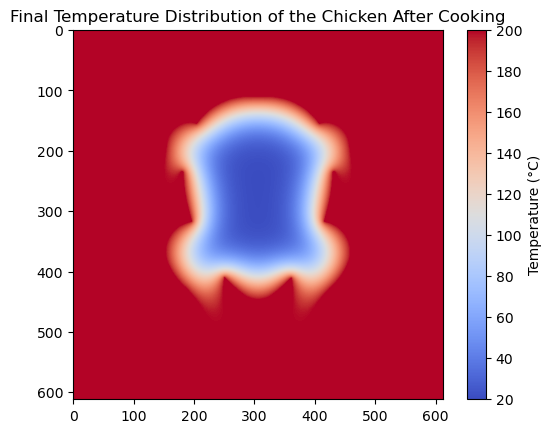

In [7]:
# Display the final temperature distribution after simulation
plt.imshow(T_final, cmap='coolwarm', vmin=T_chicken, vmax=T_oven)
plt.colorbar(label="Temperature (°C)")
plt.title("Final Temperature Distribution of the Chicken After Cooking")
plt.show()

Not a great cooking to be honest... wings and legs are overdone, but the inside is still cold.

## Numba CUDA implementation

Write the equivalent implementation for the GPU using Numba and CUDA.

There are several possible implementation that could be tested.
Some of them will be particularly problematic due to the way threads in a GPU are executed.

Try to implement first the following configuration:
- Write one single CUDA kernel that performs the evolution over all time steps  
- Use a 2D grid of threads per block (max dimension `(32,32)` threads per block due to HW limitation)
- Decide if (and where, if this is the case) to implement thread synchronization 

**WARNING** It's possible that in the case of naive implementations, the kernel run time exceeds 5s. This is however set as an hard limit by the Jetson Nano due to its inherent limitations, and the resulting application could thus fail with an error similar to:

```c
CudaAPIError: [702] Call to cuCtxSynchronize results in CUDA_ERROR_LAUNCH_TIMEOUT
```

Consider disabling the timeout by using the script provided under `/MCP/disable_timeout.sh`
```bash
sudo ./MCP/disable_timeout.sh
```

In [8]:
@cuda.jit
def heat_equation_gpu(Temp, Temp_new, Mask, Alpha, Dt_dx2, Num_steps, Width, Height):
    # Get the 2D thread indices within the grid
    i, j = cuda.grid(2)

    # Check that the thread index is within the boundaries of the temperature array
    if (1 <= i < Width - 1) and (1 <= j < Height - 1):
        # Only proceed if the current pixel is part of the "chicken" as defined by the mask
        if Mask[i, j]:  
            # Loop over all time steps
            for _ in range(Num_steps):
                # Compute the updated temperature at pixel (i, j) using the heat equation
                Temp_new[i, j] = Temp[i, j] + Alpha * Dt_dx2 * (
                    Temp[i + 1, j] + Temp[i - 1, j] +
                    Temp[i, j + 1] + Temp[i, j - 1] - 
                    4 * Temp[i, j]
                )

                # Synchronize threads to ensure Temp_new is fully updated before moving to the next step
                cuda.syncthreads()
                
                # Copy Temp_new values back to Temp for the next iteration
                Temp[i, j] = Temp_new[i, j]
                
                # Synchronize threads again to make sure all threads are aligned before the next time step
                cuda.syncthreads()

> **Sidenote** 
> 
> The `for` loop over `Num_steps` is placed outside of the `if` conditions to ensure all threads execute the loop and synchronize consistently at each `cuda.syncthreads()` call. This setup avoids potential race conditions and ensures data integrity across threads.
> 
> However, this structure also introduces some inefficiency: threads that do not meet the conditions (i.e., threads not involved in updating "chicken" pixels) are still executing the loop without performing any meaningful computation. These threads essentially "idle" through the loop, waiting at each synchronization point.
> 
> For this naive implementation, we’ll proceed with the current configuration to ensure that synchronization is handled correctly across all threads.

In [9]:
# Transfer data to the GPU
T = cuda.to_device(T_initial)  # Temperature field
T_new = cuda.to_device(T_initial)  # Buffer for the updated temperature field
M = cuda.to_device(mask)  # Mask indicating the chicken pixels

In [10]:
# Configure the thread grid for CUDA kernel launch
BLOCK_SIZE = 32  # Maximum 2D block dimension size due to hardware limits
threads_per_block = (BLOCK_SIZE, BLOCK_SIZE)

# Calculate the number of blocks in each dimension, accounting for any remainder pixels
blocks_per_grid_x = (T_initial.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (T_initial.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)


In [11]:
num_steps = np.int32(time)  # Total number of time steps for the simulation

# Launch the CUDA kernel on the GPU
heat_equation_gpu[blocks_per_grid, threads_per_block](
    T, T_new, M, alpha, dt_dx2, num_steps, width, height
)

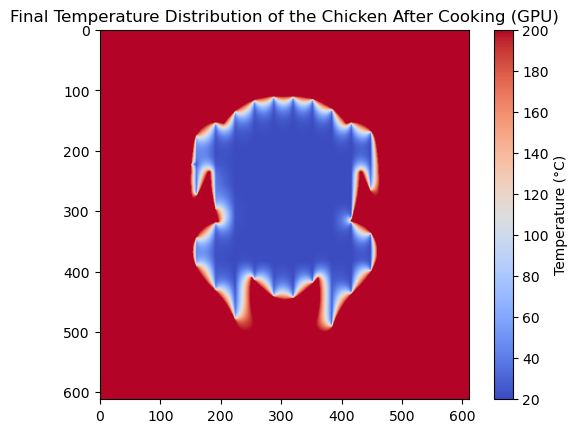

In [12]:
# Copy the final temperature distribution back to the host
T_final = T.copy_to_host()

# Display the final temperature distribution
plt.imshow(T_final, cmap='coolwarm', vmin=T_chicken, vmax=T_oven)
plt.colorbar(label="Temperature (°C)")
plt.title("Final Temperature Distribution of the Chicken After Cooking (GPU)")
plt.show()

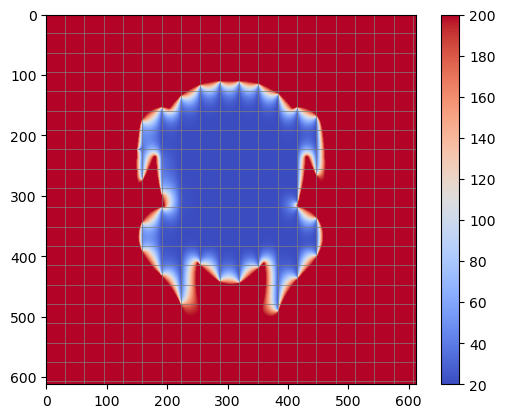

In [13]:
# plot the resulting image - with grids sized as the thread blocks
plt.imshow(T_final, cmap='coolwarm', vmin=T_chicken, vmax=T_oven)

ax = plt.gca()

for x in range(-1, image.shape[1], BLOCK_SIZE):
    ax.axvline(x=x, color='grey', linestyle='-', linewidth=0.5)
for y in range(-1, image.shape[0], BLOCK_SIZE):
    ax.axhline(y=y, color='grey', linestyle='-', linewidth=0.5)

plt.xlim(0,T_final.shape[0])
plt.ylim(T_final.shape[1],0)

plt.colorbar()

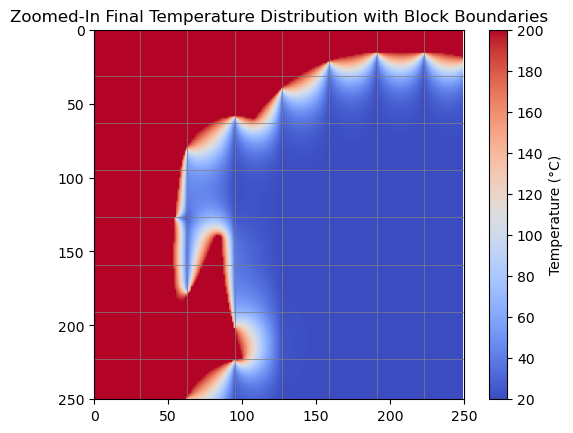

In [14]:
# Zoom into a specific region of the final temperature distribution for detailed inspection
T_final_zoom = T_final[BLOCK_SIZE*3:BLOCK_SIZE*3+250, BLOCK_SIZE*3:BLOCK_SIZE*3+250]

# Plot the zoomed-in temperature distribution
plt.imshow(T_final_zoom, cmap='coolwarm')
plt.colorbar(label="Temperature (°C)")

# Add grid lines to indicate block boundaries for visualization
ax = plt.gca()
for x in range(-1, 250, BLOCK_SIZE):
    ax.axvline(x=x, color='grey', linestyle='-', linewidth=0.5)
for y in range(-1, 250, BLOCK_SIZE):
    ax.axhline(y=y, color='grey', linestyle='-', linewidth=0.5)

# Set plot limits to match the zoomed area
plt.xlim(0, T_final_zoom.shape[0])
plt.ylim(T_final_zoom.shape[1], 0)
plt.title("Zoomed-In Final Temperature Distribution with Block Boundaries")
plt.show()

## Numba CUDA Alternative Implementation

In the naive CUDA implementation, all timesteps are processed within a single kernel launch, with each thread performing the update calculations for each time step and synchronizing after each step. This approach leads to several potential issues, one of the most visible ones being the boundary conditions of each block acting as the "limit" for the heat exchange computation.

In this case, try to implement alternative solutions for this problem, by reverting to a simpler approach:
- Write a simpler kernel to perform individual timesteps, and loop over all time steps...

In [15]:
# Numba CUDA kernel function for a single time step of the heat equation
@cuda.jit
def heat_equation_gpu_1step(Temp, Temp_new, Mask, Alpha, Dt_dx2, Width, Height):
    # Calculate global thread (i, j) index in 2D grid
    i, j = cuda.grid(2)

    # Check bounds and apply mask
    if (1 <= i < Width - 1) and (1 <= j < Height - 1):
        if Mask[i, j]:  
            # Update temperature for the current pixel based on the heat equation
            Temp_new[i, j] = Temp[i, j] + Alpha * Dt_dx2 * (
                Temp[i + 1, j] + Temp[i - 1, j] +
                Temp[i, j + 1] + Temp[i, j - 1] - 
                4 * Temp[i, j]
            )

In [16]:
# Transfer data to the GPU
T = cuda.to_device(T_initial)  
T_new = cuda.to_device(T_initial)
M = cuda.to_device(mask)  

In [17]:
# Loop over time steps, updating the temperature distribution
for step in range(num_steps):
    # Launch the kernel for a single time step
    heat_equation_gpu_1step[blocks_per_grid, threads_per_block](
        T, T_new, M, alpha, dt_dx2, width, height
    )    
    
    # Synchronize the device to ensure the kernel execution is complete
    cuda.synchronize()
    
    # Swap the temperature arrays for the next time step
    T, T_new = T_new, T

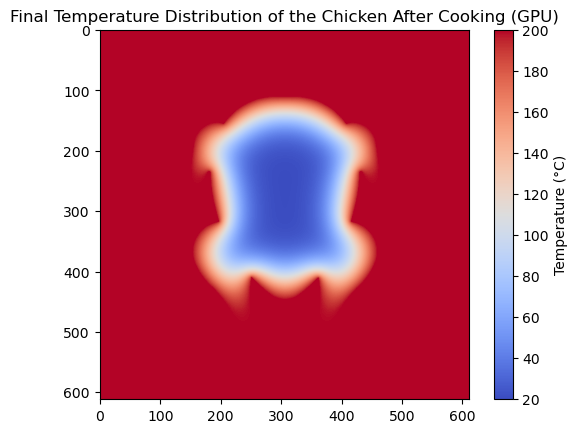

In [18]:
# Copy the final temperature distribution back to the host
T_final = T.copy_to_host()

# Display the final temperature distribution
plt.imshow(T_final, cmap='coolwarm', vmin=T_chicken, vmax=T_oven)
plt.colorbar(label="Temperature (°C)")
plt.title("Final Temperature Distribution of the Chicken After Cooking (GPU)")
plt.show()